# Additive Means in GPR

Generally, we define a mean as a single item that returns a single distribution for values of x. However, can we use two means added together to get a distribution?

In [1]:
import torch
import gpytorch
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
%matplotlib inline

In [2]:
class SineMean(gpytorch.means.Mean):
    def __init__(self):
        super(SineMean, self).__init__()
        self.register_parameter(name = 'T', parameter = torch.nn.Parameter(torch.randn(())))
        self.pi = torch.Tensor([np.pi])
        
    def forward(self, x):
        return torch.sin(2 * self.pi * self.T)
    
class CosineMean(gpytorch.means.Mean):
    def __init__(self):
        super(CosineMean, self).__init__()
        self.register_parameter(name = 'T', parameter = torch.nn.Parameter(torch.randn(())))
        self.pi = torch.Tensor([np.pi])
        
    def forward(self, x):
        return torch.cos(2 * self.pi * self.T)

In [3]:
class AdditiveMeansGP(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(AdditiveMeansGP, self).__init__(train_x, train_y, likelihood)
        self.mean_module = SineMean() + CosineMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())
        
    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

In [102]:
train_x = torch.linspace(0, 5, 501)
train_y = torch.sin(2 * torch.Tensor([np.pi]) * train_x) + torch.cos(2 * torch.Tensor([np.pi]) * train_x) + torch.randn(train_x.size()) * 0.1
true_y = torch.sin(2 * torch.Tensor([np.pi]) * train_x) + torch.cos(2 * torch.Tensor([np.pi]) * train_x)

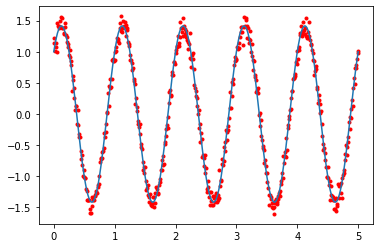

In [103]:
plt.plot(train_x, train_y, 'r.')
plt.plot(train_x, true_y)

In [104]:
likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = AdditiveMeansGP(train_x, train_y, likelihood)

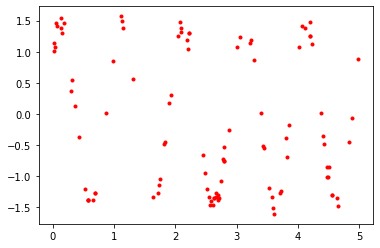

In [105]:
torch.manual_seed(1234)
n = torch.randint(0,501, (100,))
train_x = train_x[n]
train_y = train_y[n]
plt.plot(train_x, train_y, 'r.')

In [106]:
class AddedMean(gpytorch.means.Mean):
    def __init__(self):
        super(AddedMean, self).__init__()
        self.register_parameter(name = 'T', parameter = torch.nn.Parameter(torch.randn(())))
        self.pi = torch.Tensor([np.pi])
        
    def forward(self, x):
        res = torch.sin(self.T * x) + torch.cos(self.T * x)
        return res.squeeze()

In [107]:
class AdditiveMeansGP(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(AdditiveMeansGP, self).__init__(train_x, train_y, likelihood)
        self.mean_module = AddedMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())
        
    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

In [108]:
likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = AdditiveMeansGP(train_x, train_y, likelihood)

In [109]:
model.train()
likelihood.train()

optimizer = torch.optim.Adam(model.parameters(), lr = 0.1)
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

for _ in tqdm(range(500)):
    optimizer.zero_grad()
    output = model(train_x)
    loss = -mll(output, train_y)
    loss.backward()
    optimizer.step()

In [110]:
model.eval()
likelihood.eval()

GaussianLikelihood(
  (noise_covar): HomoskedasticNoise(
    (raw_noise_constraint): GreaterThan(1.000E-04)
  )
)

In [111]:
test_x = torch.linspace(0, 5, 501)

f_preds = model(test_x)
y_preds = likelihood(model(test_x))

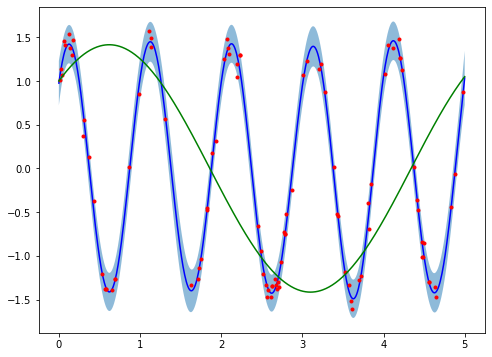

In [112]:
with torch.no_grad():
    
    f, ax = plt.subplots(1, 1, figsize = (8,6))
    lower, upper = y_preds.confidence_region()
    ax.plot(test_x, y_preds.mean, 'b')
    ax.plot(train_x, train_y, 'r.')
    ax.fill_between(test_x, lower, upper, alpha = 0.5)
    ax.plot(test_x, (torch.sin(model.mean_module.T * test_x) 
                     + torch.cos(model.mean_module.T * test_x)).squeeze(), 'g')

In [113]:
model.state_dict()

OrderedDict([('likelihood.noise_covar.raw_noise', tensor([-4.5797])),
             ('likelihood.noise_covar.raw_noise_constraint.lower_bound',
              tensor(1.0000e-04)),
             ('likelihood.noise_covar.raw_noise_constraint.upper_bound',
              tensor(inf)),
             ('mean_module.T', tensor(1.2668)),
             ('covar_module.raw_outputscale', tensor(5.5477)),
             ('covar_module.base_kernel.raw_lengthscale', tensor([[-0.7867]])),
             ('covar_module.base_kernel.raw_lengthscale_constraint.lower_bound',
              tensor(0.)),
             ('covar_module.base_kernel.raw_lengthscale_constraint.upper_bound',
              tensor(inf)),
             ('covar_module.raw_outputscale_constraint.lower_bound',
              tensor(0.)),
             ('covar_module.raw_outputscale_constraint.upper_bound',
              tensor(inf))])

The green line shows that instead of learning the exact constant for the model, it has learned a constant which fits the data adequately. This is the difference between a scipy optimize based regression and a GPR. This also shows that GPR is excellent for interpolation, while extrapolation may not be straight-forward (due to the risk of aliasing in this case).